# Setup and Imports

In [ ]:
!pip install --quiet optuna lazypredict endaq umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.3 MB/s eta 0:00:00


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

drive_root_folder = "/content/drive/MyDrive/221 Project data"

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from scipy import signal
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap, SpectralEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import numpy as np
import pywt # discrete wavelet transform
import endaq # psd
import optuna
import lazypredict
import time
import umap

from lazypredict.Supervised import LazyClassifier

In [ ]:
df = pd.read_csv(f'{drive_root_folder}/mine_impact_data_2019.csv', header = None)
data = df.transpose()
print(data.shape)

(3309, 36002)


In [ ]:
data.reset_index().groupby([0,1])["index"].count()

0     1   
1.00  0.00    543
      1.00    303
2.00  0.00    296
      1.00    294
3.00  0.00    609
      1.00    273
4.00  0.00    219
      1.00    132
5.00  0.00    545
      1.00     95
Name: index, dtype: int64

In [ ]:
data.reset_index().groupby([1])["index"].count()

1
0.00    2212
1.00    1097
Name: index, dtype: int64

# EDA

Plot sample of recordings over time

In [ ]:
# For plotting samples of raw data
def plot_sample(class_label, num=10, sample_ids=[]):
  def format_time(x, pos):
    return f'{x / 48000:.2f}'
  if sample_ids == []:
    sample_df = data[data[1]==class_label].sample(num).iloc[:,:6000]
  else:
    sample_df = data[data.index.isin(sample_ids)].iloc[:,:6000]
  record_ids = sample_df.index.tolist()
  sample_df.reset_index(drop=True, inplace=True)
  sample_df.index = sample_df.index + 1
  melted_df = sample_df.iloc[:,1:].melt(id_vars=1,var_name='Time', value_name='Value', ignore_index=False)
  melted_df.reset_index(inplace=True)
  melted_df.rename(columns={"index": "Sample", 1: "Label"}, inplace=True)

  # Create a color palette with the same number of colors as the number of unique recording IDs
  num_recordings = melted_df["Sample"].nunique()
  palette = sns.color_palette("tab10", num_recordings)

  fig, ax = plt.subplots(figsize=(10, 8))

  # Set the background color to wheat
  fig.patch.set_facecolor('#E4D4C8')
  ax.set_facecolor('#E4D4C8')

  # Create the lineplot with different colors per recording ID
  sns.lineplot(data=melted_df, x='Time', y='Value', hue="Sample", estimator=None, palette=palette, linewidth=0.5, ax=ax)

  # Move the legend to the right side and set its background color to wheat
  legend = plt.legend(title="Sample", loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
  legend.get_frame().set_facecolor('#E4D4C8')
  legend.get_frame().set_alpha(1)  # Make the legend background opaque

  # Increase font size for legend text
  plt.setp(legend.get_texts(), fontsize=12)  # Change 12 to your desired font size

  # Increase font size for legend title
  plt.setp(legend.get_title(), fontsize=14)  # Change 14 to your desired font size

  # Set the labels and title
  plt.xlabel('Time (seconds)', fontsize=12)
  plt.ylabel('Value', fontsize=12)

  plt.ylim([-0.6,0.6])

  # Add a grid
  plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

  # Set the x-axis tick formatter
  formatter = FuncFormatter(format_time)
  ax.xaxis.set_major_formatter(formatter)

  # Increase font size for both x and y tick labels
  ax.tick_params(axis='x', which='major', labelsize=11)  # For x-axis
  ax.tick_params(axis='y', which='major', labelsize=11)  # For y-axis

  return record_ids

Plot samples from drummy and tight here

In [ ]:
# save these samples
class_0_sample_record_ids = [1955, 1140, 2044, 1560, 1461, 561, 2432, 1534, 2210, 347]
class_1_sample_record_ids = [2266, 483, 1397, 1130, 1629, 2962, 1036, 1608, 1779, 490]

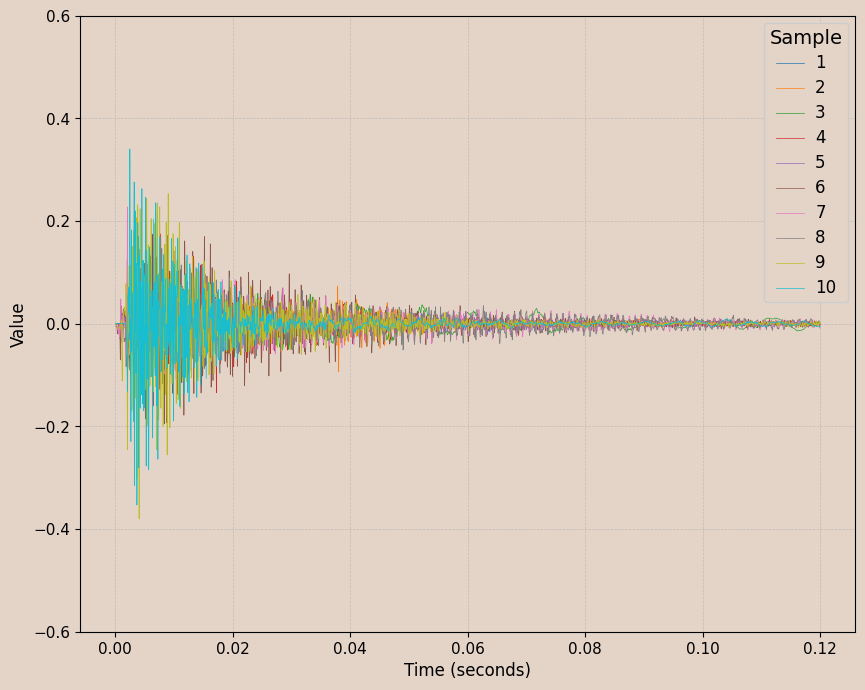

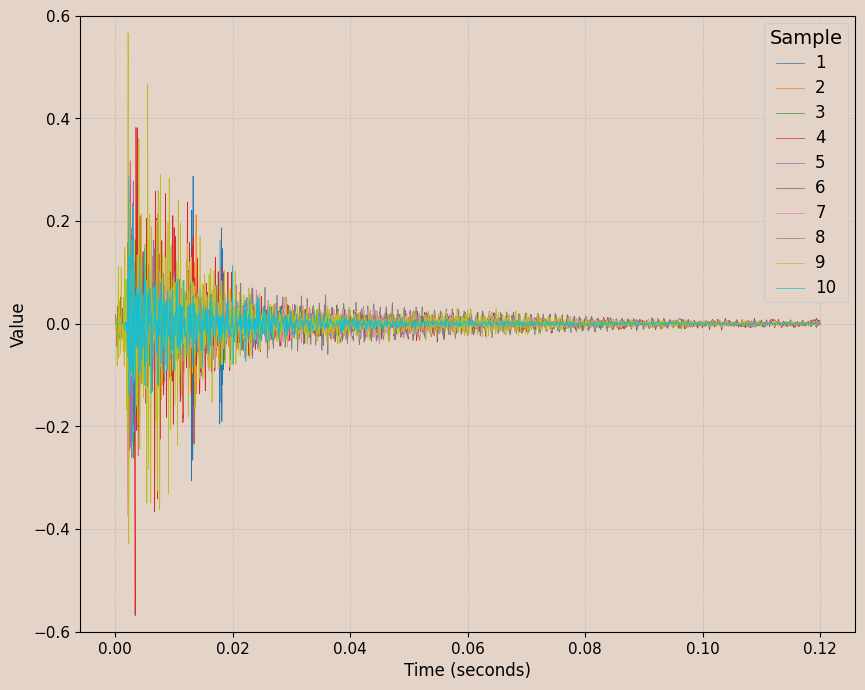

In [ ]:
class_0_sample_record_ids = plot_sample(0, num=10, sample_ids=class_0_sample_record_ids) # drummy
class_1_sample_record_ids = plot_sample(1, num=10, sample_ids=class_1_sample_record_ids) # tight

In [ ]:
targets = data.iloc[:, :2]
targets.head()


,0,1
0,1.00,0.00
1,1.00,0.00
2,1.00,0.00
3,1.00,0.00
4,1.00,0.00


In [ ]:
inp = data.iloc[:, 2:]
inp.head()

,2,3,4,5,6,7,8,9,10,11,...,35992,35993,35994,35995,35996,35997,35998,35999,36000,36001
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# class counts
print(targets[1].value_counts())

1
0.00    2212
1.00    1097
Name: count, dtype: int64


In [ ]:
#split the data------------------------------------------

X = inp
y = targets[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
def add_statistical_features(data):
  features = []
  for row in data:
      mean = np.mean(row)
      std = np.std(row)
      skewness = np.mean((row - mean) ** 3) / (std ** 3)
      kurtosis = np.mean((row - mean) ** 4) / (std ** 4)
      max_val = np.max(row)
      min_val = np.min(row)
      stat_features = np.array([mean, std, skewness, kurtosis, max_val, min_val])
      new_row_features = np.concatenate([row, stat_features])
      features.append(new_row_features)
  return np.array(features)

def create_wavelet_features(data, wavelet="db4", level=5):
  wavelet_feature_list = []

  for i, recording_signal in data.iterrows():
      coefficients = pywt.wavedec(recording_signal, wavelet, level=level)
      features = np.concatenate([coeff for coeff in coefficients])
      wavelet_feature_list.append(features)

  wavelet_features = np.array(wavelet_feature_list)
  wavelet_features = add_statistical_features(wavelet_features)
  return wavelet_features

def extract_psd_features(data, fs=48000, nperseg=1024):
  freq, psd_features = signal.welch(data, fs=fs, nperseg=nperseg, axis=1)
  psd_features = add_statistical_features(psd_features)
  return psd_features


def dwt_objective(trial):
    wavelet = trial.suggest_categorical('wavelet', ['db2', 'db4', 'db6', 'db8', 'db10', 'db12', 'db14', 'db16', 'db18', 'db20', 'db22', 'db24', 'db26', 'db28', 'db30', 'db32', 'db34', 'db36', 'db38'])
    level = trial.suggest_int('level', 3, 9)
    first_m_columns = 8000

    X_train_m = X_train.iloc[:,:first_m_columns + 1].reset_index(drop=True)
    X_test_m = X_test.iloc[:,:first_m_columns + 1].reset_index(drop=True)

    clf = xgb.XGBClassifier()

    X_train_dwt = create_wavelet_features(X_train_m, wavelet, level)
    clf.fit(X_train_dwt, y_train)

    X_test_dwt = create_wavelet_features(X_test_m, wavelet, level)
    y_pred = clf.predict(X_test_dwt)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

Trim first M features

In [ ]:
# %%time
# # i=8000 acc=0.969
# # logres = 31k 0.69

# num_feature_results = []
# for i in range(1, X_train.shape[1] + 1, 1000):
#   start_time = time.time()
#   clf = xgb.XGBClassifier()
#   clf.fit(X_train.iloc[:,:i], y_train)

#   y_pred = clf.predict(X_test.iloc[:,:i])

#   accuracy = accuracy_score(y_test, y_pred)

#   end_time = time.time()
#   execution_time = end_time - start_time

#   row = {
#       "feature_num": i,
#       "accuracy": accuracy,
#       "execution_time": execution_time
#   }
#   num_feature_results.append(row)
#   print(f"Run for {i}. Accuracy: {accuracy}. Time taken: {execution_time}")

Run for 1. Accuracy: 0.6465256797583081. Time taken: 0.11102700233459473
Run for 1001. Accuracy: 0.7280966767371602. Time taken: 8.29999041557312
Run for 2001. Accuracy: 0.7598187311178247. Time taken: 14.146589517593384
Run for 3001. Accuracy: 0.7764350453172205. Time taken: 19.557540893554688
Run for 4001. Accuracy: 0.8096676737160121. Time taken: 26.798399448394775
Run for 5001. Accuracy: 0.8293051359516617. Time taken: 31.746946811676025
Run for 6001. Accuracy: 0.8429003021148036. Time taken: 35.646729469299316
Run for 7001. Accuracy: 0.8474320241691843. Time taken: 38.96363663673401
Run for 8001. Accuracy: 0.851963746223565. Time taken: 43.28964352607727
Run for 9001. Accuracy: 0.8549848942598187. Time taken: 48.28961730003357
Run for 10001. Accuracy: 0.8640483383685801. Time taken: 53.928375482559204
Run for 11001. Accuracy: 0.8685800604229608. Time taken: 56.3692889213562
Run for 12001. Accuracy: 0.8731117824773413. Time taken: 59.58158802986145
Run for 13001. Accuracy: 0.882175

In [ ]:
#  feature_num_results_df = pd.DataFrame(num_feature_results)
#  feature_num_results_df.to_csv(f"{drive_root_folder}/feature_trimming_results.csv", index=False)

In [ ]:
data = pd.read_csv(f"{drive_root_folder}/feature_trimming_results.csv")
data

,feature_num,accuracy,execution_time
0,1,0.65,0.11
1,1001,0.73,8.30
2,2001,0.76,14.15
3,3001,0.78,19.56
4,4001,0.81,26.80
5,5001,0.83,31.75
6,6001,0.84,35.65
7,7001,0.85,38.96
8,8001,0.85,43.29
9,9001,0.85,48.29


In [ ]:
feature_num_results_df

,feature_num,accuracy,execution_time
0,1,0.65,0.11
1,1001,0.73,8.30
2,2001,0.76,14.15
3,3001,0.78,19.56
4,4001,0.81,26.80
5,5001,0.83,31.75
6,6001,0.84,35.65
7,7001,0.85,38.96
8,8001,0.85,43.29
9,9001,0.85,48.29


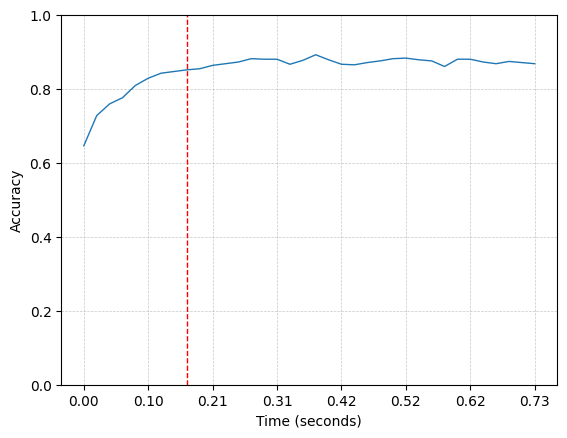

In [ ]:
def format_time(x, pos):
    return f'{x / 48000:.2f}'

sns.lineplot(feature_num_results_df, x="feature_num", y="accuracy", linewidth=1)
# Set the labels and title
plt.xlabel('Features')
plt.ylabel('Accuracy')

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.xlabel('Time (seconds)')
plt.ylabel('Accuracy')

plt.ylim([0,1])
# Add a vertical line at x=8000
plt.axvline(x=8000, color='red', linestyle='--', linewidth=1)

# Set the x-axis tick formatter
formatter = FuncFormatter(format_time)
plt.gca().xaxis.set_major_formatter(formatter)

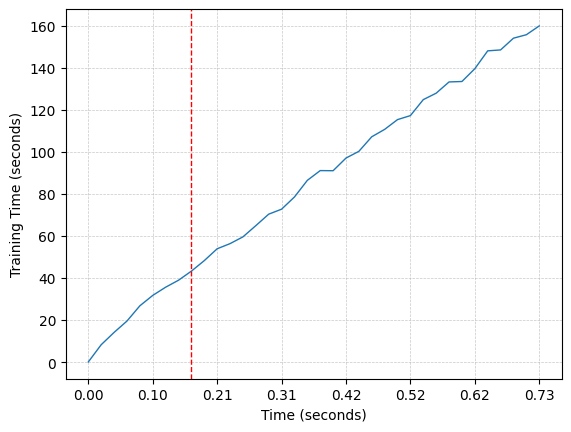

In [ ]:
sns.lineplot(feature_num_results_df, x="feature_num", y="execution_time", linewidth=1)

# Set the labels and title
plt.xlabel('Features')
plt.ylabel('Time Taken (seconds)')

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.xlabel('Time (seconds)')
plt.ylabel('Training Time (seconds)')
# Add a vertical line at x=8000
plt.axvline(x=8000, color='red', linestyle='--', linewidth=1)

# Set the x-axis tick formatter
formatter = FuncFormatter(format_time)
plt.gca().xaxis.set_major_formatter(formatter)

In [ ]:
# sns.lineplot(feature_num_results_df, x="feature_num", y="accuracy")

# Model Training

In [ ]:
M_features = 18000

def preprocess_data_from_type(data, method):
  if method == "DWT":
    return create_wavelet_features(data.iloc[:,:M_features])
  elif method == "PSD":
    return extract_psd_features(data.iloc[:,:M_features])

def dim_reduce_data_from_type(data, method):
  if method == None:
    return None, data
  elif method == "PCA":
    reducer = PCA(n_components=500)
  elif method == "KPCA":
    reducer = KernelPCA(n_components=500, kernel='rbf')
  elif method == 'UMAP':
    reducer = umap.UMAP(n_components=500, random_state=42)
  data = reducer.fit_transform(data)
  return reducer, data


In [ ]:
%%time
## 8 tables generation

output_models = []

for preprocessor in ["DWT", "PSD"]:
  for dim_reducer in [None, "PCA", "KPCA", "UMAP"]:
    iter_name = f"{preprocessor}-{dim_reducer}"
    print(f"Processing: {iter_name}")
    X_train_out = preprocess_data_from_type(X_train.iloc[:,:M_features], preprocessor)
    X_test_out = preprocess_data_from_type(X_test.iloc[:,:M_features], preprocessor)

    if dim_reducer is not None:
      reducer, X_train_out = dim_reduce_data_from_type(X_train_out, dim_reducer)
      X_test_out = reducer.transform(X_test_out)

    clf = LazyClassifier(verbose=1,ignore_warnings=False, custom_metric=None)
    models, predictions = clf.fit(X_train_out, X_test_out, y_train, y_test)
    models["Trial"] = iter_name

    output_models.append(models)

Processing: DWT-None


  3%|▎         | 1/29 [06:18<2:56:30, 378.22s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.8640483383685801, 'Balanced Accuracy': 0.845315769401239, 'ROC AUC': 0.845315769401239, 'F1 Score': 0.8638896213489468, 'Time taken': 378.2234525680542}


  7%|▋         | 2/29 [14:52<3:26:12, 458.22s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.8383685800604229, 'Balanced Accuracy': 0.7741787521774535, 'ROC AUC': 0.7741787521774535, 'F1 Score': 0.8279782767086429, 'Time taken': 514.221123456955}


 10%|█         | 3/29 [14:56<1:48:40, 250.79s/it]

{'Model': 'BernoulliNB', 'Accuracy': 0.7990936555891238, 'Balanced Accuracy': 0.771385427296247, 'ROC AUC': 0.771385427296247, 'F1 Score': 0.7987398621739634, 'Time taken': 3.9478752613067627}


 14%|█▍        | 4/29 [15:37<1:09:56, 167.85s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.6691842900302115, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.5365586253092918, 'Time taken': 40.696154832839966}


 17%|█▋        | 5/29 [15:39<43:18, 108.25s/it]  

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 21%|██        | 6/29 [17:06<38:41, 100.95s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.7386706948640483, 'Balanced Accuracy': 0.6985322160033809, 'ROC AUC': 0.698532216003381, 'F1 Score': 0.7369069801298539, 'Time taken': 86.78541588783264}


 24%|██▍       | 7/29 [17:09<25:17, 68.96s/it] 

{'Model': 'DummyClassifier', 'Accuracy': 0.6691842900302115, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.5365586253092918, 'Time taken': 3.101222276687622}


 28%|██▊       | 8/29 [17:12<16:47, 47.97s/it]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.6963746223564955, 'Balanced Accuracy': 0.6507673912819403, 'ROC AUC': 0.6507673912819404, 'F1 Score': 0.6943254509023156, 'Time taken': 3.009242296218872}


 31%|███       | 9/29 [17:26<12:25, 37.28s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.8066465256797583, 'Balanced Accuracy': 0.7227702361441809, 'ROC AUC': 0.7227702361441809, 'F1 Score': 0.7872790272217844, 'Time taken': 13.785181522369385}


 34%|███▍      | 10/29 [17:29<08:30, 26.89s/it]

{'Model': 'GaussianNB', 'Accuracy': 0.6525679758308157, 'Balanced Accuracy': 0.5914839667274807, 'ROC AUC': 0.5914839667274808, 'F1 Score': 0.6460261592045207, 'Time taken': 3.6346402168273926}


 38%|███▊      | 11/29 [17:33<05:55, 19.75s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.6238670694864048, 'Balanced Accuracy': 0.5377150396322294, 'ROC AUC': 0.5377150396322294, 'F1 Score': 0.6039482677743707, 'Time taken': 3.5639004707336426}


 41%|████▏     | 12/29 [17:38<04:21, 15.36s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.6691842900302115, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.5365586253092918, 'Time taken': 5.308779239654541}


 45%|████▍     | 13/29 [17:43<03:15, 12.19s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.6691842900302115, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.5365586253092918, 'Time taken': 4.905166864395142}


 48%|████▊     | 14/29 [18:10<04:07, 16.47s/it]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.6450151057401813, 'Balanced Accuracy': 0.5350454044136594, 'ROC AUC': 0.5350454044136594, 'F1 Score': 0.6045263204453016, 'Time taken': 26.33671522140503}


 52%|█████▏    | 15/29 [18:23<03:39, 15.68s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.6102719033232629, 'Balanced Accuracy': 0.5425647051547667, 'ROC AUC': 0.5425647051547667, 'F1 Score': 0.6023256747916121, 'Time taken': 13.844003200531006}


 55%|█████▌    | 16/29 [18:31<02:50, 13.13s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.6314199395770392, 'Balanced Accuracy': 0.5445128173412906, 'ROC AUC': 0.5445128173412908, 'F1 Score': 0.6106863975073518, 'Time taken': 7.210387706756592}


 59%|█████▊    | 17/29 [18:34<02:01, 10.11s/it]

{'Model': 'NearestCentroid', 'Accuracy': 0.6404833836858006, 'Balanced Accuracy': 0.5478215158168156, 'ROC AUC': 0.5478215158168156, 'F1 Score': 0.6152007457595444, 'Time taken': 3.081176519393921}


 62%|██████▏   | 18/29 [20:20<07:07, 38.89s/it]

{'Model': 'NuSVC', 'Accuracy': 0.6706948640483383, 'Balanced Accuracy': 0.5276807157508477, 'ROC AUC': 0.5276807157508477, 'F1 Score': 0.5892017277028393, 'Time taken': 105.87258338928223}


 66%|██████▌   | 19/29 [20:25<04:48, 28.89s/it]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.6087613293051359, 'Balanced Accuracy': 0.5448993475370296, 'ROC AUC': 0.5448993475370296, 'F1 Score': 0.6028694399305616, 'Time taken': 5.588812351226807}


 69%|██████▉   | 20/29 [20:30<03:13, 21.53s/it]

{'Model': 'Perceptron', 'Accuracy': 0.6178247734138973, 'Balanced Accuracy': 0.5759145304431182, 'ROC AUC': 0.5759145304431182, 'F1 Score': 0.6204873220750771, 'Time taken': 4.3672990798950195}


 72%|███████▏  | 21/29 [20:50<02:48, 21.09s/it]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.5196374622356495, 'Balanced Accuracy': 0.5418019522351754, 'ROC AUC': 0.5418019522351752, 'F1 Score': 0.5322956642443047, 'Time taken': 20.077318906784058}


 76%|███████▌  | 22/29 [21:34<03:16, 28.08s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.8157099697885196, 'Balanced Accuracy': 0.7457043610913552, 'ROC AUC': 0.7457043610913552, 'F1 Score': 0.8027499621120355, 'Time taken': 44.3904595375061}


 79%|███████▉  | 23/29 [21:39<02:06, 21.16s/it]

{'Model': 'RidgeClassifier', 'Accuracy': 0.6374622356495468, 'Balanced Accuracy': 0.5651896059453497, 'ROC AUC': 0.5651896059453497, 'F1 Score': 0.6257951723963933, 'Time taken': 5.020933151245117}


 83%|████████▎ | 24/29 [21:47<01:25, 17.04s/it]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.6374622356495468, 'Balanced Accuracy': 0.5651896059453497, 'ROC AUC': 0.5651896059453497, 'F1 Score': 0.6257951723963933, 'Time taken': 7.401452541351318}


 86%|████████▌ | 25/29 [21:54<00:56, 14.04s/it]

{'Model': 'SGDClassifier', 'Accuracy': 0.6555891238670695, 'Balanced Accuracy': 0.5036952286712638, 'ROC AUC': 0.5036952286712638, 'F1 Score': 0.5583640386758482, 'Time taken': 7.040131330490112}


 90%|████████▉ | 26/29 [23:36<02:01, 40.66s/it]

{'Model': 'SVC', 'Accuracy': 0.6691842900302115, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.5365586253092918, 'Time taken': 102.76355457305908}
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'


 97%|█████████▋| 28/29 [25:15<00:44, 44.57s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.9033232628398792, 'Balanced Accuracy': 0.8723522681591886, 'ROC AUC': 0.8723522681591886, 'F1 Score': 0.9011983397611801, 'Time taken': 98.24931740760803}
[LightGBM] [Info] Number of positive: 878, number of negative: 1769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.958762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4599945
[LightGBM] [Info] Number of data points in the train set: 2647, number of used features: 18039
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331696 -> initscore=-0.700523
[LightGBM] [Info] Start training from score -0.700523


100%|██████████| 29/29 [26:49<00:00, 55.50s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.9169184290030211, 'Balanced Accuracy': 0.892900213364668, 'ROC AUC': 0.892900213364668, 'F1 Score': 0.91566725558371, 'Time taken': 94.44871425628662}
Processing: DWT-PCA



  3%|▎         | 1/29 [00:09<04:34,  9.80s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.6963746223564955, 'Balanced Accuracy': 0.6369141490666584, 'ROC AUC': 0.6369141490666584, 'F1 Score': 0.6889591093653342, 'Time taken': 9.799755334854126}


 10%|█         | 3/29 [00:21<02:34,  5.96s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.6873111782477341, 'Balanced Accuracy': 0.5885824133914674, 'ROC AUC': 0.5885824133914674, 'F1 Score': 0.6564530174871698, 'Time taken': 11.580128908157349}
{'Model': 'BernoulliNB', 'Accuracy': 0.6993957703927492, 'Balanced Accuracy': 0.633399301153406, 'ROC AUC': 0.6333993011534061, 'F1 Score': 0.6889002534356312, 'Time taken': 0.14125633239746094}


 14%|█▍        | 4/29 [00:33<03:25,  8.22s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.6918429003021148, 'Balanced Accuracy': 0.5469453807064741, 'ROC AUC': 0.5469453807064741, 'F1 Score': 0.6085595127974474, 'Time taken': 11.679067850112915}
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 28%|██▊       | 8/29 [00:35<00:53,  2.53s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.622356495468278, 'Balanced Accuracy': 0.5781460981065174, 'ROC AUC': 0.5781460981065173, 'F1 Score': 0.6240229611818106, 'Time taken': 1.8812174797058105}
{'Model': 'DummyClassifier', 'Accuracy': 0.6691842900302115, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.5365586253092918, 'Time taken': 0.08240365982055664}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.5634441087613293, 'Balanced Accuracy': 0.5225836709030376, 'ROC AUC': 0.5225836709030376, 'F1 Score': 0.5692574220300677, 'Time taken': 0.09306859970092773}


 34%|███▍      | 10/29 [00:36<00:32,  1.70s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.6978851963746223, 'Balanced Accuracy': 0.5537689270952513, 'ROC AUC': 0.5537689270952514, 'F1 Score': 0.6162348164680855, 'Time taken': 1.2643465995788574}
{'Model': 'GaussianNB', 'Accuracy': 0.5030211480362538, 'Balanced Accuracy': 0.5674830184400672, 'ROC AUC': 0.5674830184400672, 'F1 Score': 0.503274035781153, 'Time taken': 0.1020810604095459}


 38%|███▊      | 11/29 [00:36<00:23,  1.29s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.5438066465256798, 'Balanced Accuracy': 0.6095014275848563, 'ROC AUC': 0.6095014275848563, 'F1 Score': 0.5456056837131452, 'Time taken': 0.14049577713012695}


 41%|████▏     | 12/29 [00:37<00:17,  1.05s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.6722054380664653, 'Balanced Accuracy': 0.504566210045662, 'ROC AUC': 0.504566210045662, 'F1 Score': 0.5435191477215259, 'Time taken': 0.418224573135376}


 45%|████▍     | 13/29 [00:37<00:14,  1.12it/s]

{'Model': 'LabelSpreading', 'Accuracy': 0.6722054380664653, 'Balanced Accuracy': 0.504566210045662, 'ROC AUC': 0.504566210045662, 'F1 Score': 0.5435191477215259, 'Time taken': 0.49072766304016113}


 48%|████▊     | 14/29 [00:38<00:11,  1.34it/s]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.7084592145015106, 'Balanced Accuracy': 0.6470979312903924, 'ROC AUC': 0.6470979312903925, 'F1 Score': 0.6998520756460681, 'Time taken': 0.3707246780395508}


 55%|█████▌    | 16/29 [00:41<00:14,  1.10s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.7522658610271903, 'Balanced Accuracy': 0.7075357926961254, 'ROC AUC': 0.7075357926961254, 'F1 Score': 0.7487163832015569, 'Time taken': 3.2962238788604736}
{'Model': 'LogisticRegression', 'Accuracy': 0.7326283987915407, 'Balanced Accuracy': 0.6824731748044157, 'ROC AUC': 0.6824731748044157, 'F1 Score': 0.7277995882837107, 'Time taken': 0.16341876983642578}


 59%|█████▊    | 17/29 [00:41<00:09,  1.23it/s]

{'Model': 'NearestCentroid', 'Accuracy': 0.6737160120845922, 'Balanced Accuracy': 0.671933784800602, 'ROC AUC': 0.671933784800602, 'F1 Score': 0.6822011841109162, 'Time taken': 0.1185295581817627}


 66%|██████▌   | 19/29 [00:44<00:09,  1.06it/s]

{'Model': 'NuSVC', 'Accuracy': 0.7583081570996979, 'Balanced Accuracy': 0.679726233546698, 'ROC AUC': 0.6797262335466979, 'F1 Score': 0.7407098084773374, 'Time taken': 2.3099050521850586}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.7009063444108762, 'Balanced Accuracy': 0.649535648391519, 'ROC AUC': 0.6495356483915191, 'F1 Score': 0.696620999231148, 'Time taken': 0.1959230899810791}


 69%|██████▉   | 20/29 [00:44<00:06,  1.41it/s]

{'Model': 'Perceptron', 'Accuracy': 0.6888217522658611, 'Balanced Accuracy': 0.6289619345063236, 'ROC AUC': 0.6289619345063236, 'F1 Score': 0.681477650917594, 'Time taken': 0.16750693321228027}


 72%|███████▏  | 21/29 [00:44<00:04,  1.64it/s]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.7779456193353474, 'Balanced Accuracy': 0.6909356092231258, 'ROC AUC': 0.6909356092231259, 'F1 Score': 0.7560318529981351, 'Time taken': 0.37038421630859375}


 79%|███████▉  | 23/29 [00:50<00:09,  1.51s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.7039274924471299, 'Balanced Accuracy': 0.568673531442943, 'ROC AUC': 0.568673531442943, 'F1 Score': 0.6354119570707794, 'Time taken': 5.562375068664551}
{'Model': 'RidgeClassifier', 'Accuracy': 0.716012084592145, 'Balanced Accuracy': 0.6481235247430863, 'ROC AUC': 0.6481235247430862, 'F1 Score': 0.7042012839879155, 'Time taken': 0.1477804183959961}


 83%|████████▎ | 24/29 [00:50<00:05,  1.16s/it]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.7099697885196374, 'Balanced Accuracy': 0.6401455415030355, 'ROC AUC': 0.6401455415030356, 'F1 Score': 0.6973318851059024, 'Time taken': 0.3243591785430908}


 86%|████████▌ | 25/29 [00:51<00:03,  1.04it/s]

{'Model': 'SGDClassifier', 'Accuracy': 0.7190332326283988, 'Balanced Accuracy': 0.6769329086654916, 'ROC AUC': 0.6769329086654917, 'F1 Score': 0.7173188054868727, 'Time taken': 0.481917142868042}


 90%|████████▉ | 26/29 [00:53<00:03,  1.30s/it]

{'Model': 'SVC', 'Accuracy': 0.716012084592145, 'Balanced Accuracy': 0.5927105558819588, 'ROC AUC': 0.5927105558819588, 'F1 Score': 0.6626158689980441, 'Time taken': 2.103750705718994}
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'


 97%|█████████▋| 28/29 [00:57<00:01,  1.60s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.7145015105740181, 'Balanced Accuracy': 0.6308327406536999, 'ROC AUC': 0.6308327406536999, 'F1 Score': 0.6940703055092075, 'Time taken': 3.8993680477142334}
[LightGBM] [Info] Number of positive: 878, number of negative: 1769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 2647, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331696 -> initscore=-0.700523
[LightGBM] [Info] Start training from score -0.700523


100%|██████████| 29/29 [01:00<00:00,  2.08s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.729607250755287, 'Balanced Accuracy': 0.6375016749641815, 'ROC AUC': 0.6375016749641815, 'F1 Score': 0.7037133887167497, 'Time taken': 2.944418430328369}
Processing: DWT-KPCA



  3%|▎         | 1/29 [00:09<04:32,  9.75s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.6616314199395771, 'Balanced Accuracy': 0.5809394229877238, 'ROC AUC': 0.5809394229877238, 'F1 Score': 0.6440777760677119, 'Time taken': 9.748750686645508}


 10%|█         | 3/29 [00:21<02:31,  5.82s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.676737160120846, 'Balanced Accuracy': 0.5656740571240092, 'ROC AUC': 0.5656740571240092, 'F1 Score': 0.6350242613180292, 'Time taken': 11.200716733932495}
{'Model': 'BernoulliNB', 'Accuracy': 0.6435045317220544, 'Balanced Accuracy': 0.578939773441768, 'ROC AUC': 0.578939773441768, 'F1 Score': 0.6356688778693521, 'Time taken': 0.11971116065979004}


 14%|█▍        | 4/29 [00:35<03:48,  9.15s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.6691842900302115, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.5365586253092918, 'Time taken': 14.246948480606079}
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 28%|██▊       | 8/29 [00:37<00:57,  2.75s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.6148036253776435, 'Balanced Accuracy': 0.5678850098436357, 'ROC AUC': 0.5678850098436357, 'F1 Score': 0.6158843540545561, 'Time taken': 1.7246458530426025}
{'Model': 'DummyClassifier', 'Accuracy': 0.6691842900302115, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.5365586253092918, 'Time taken': 0.07665491104125977}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.5709969788519638, 'Balanced Accuracy': 0.524763701207005, 'ROC AUC': 0.5247637012070049, 'F1 Score': 0.5746116480868128, 'Time taken': 0.08121752738952637}


 31%|███       | 9/29 [00:38<00:48,  2.41s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.6873111782477341, 'Balanced Accuracy': 0.5504859972994424, 'ROC AUC': 0.5504859972994424, 'F1 Score': 0.6157614608913925, 'Time taken': 1.298447608947754}
{'Model': 'GaussianNB', 'Accuracy': 0.4033232628398791, 'Balanced Accuracy': 0.5183885298452848, 'ROC AUC': 0.5183885298452848, 'F1 Score': 0.35252716766112097, 'Time taken': 0.08654046058654785}


 38%|███▊      | 11/29 [00:38<00:27,  1.51s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.5558912386706949, 'Balanced Accuracy': 0.5769710463114712, 'ROC AUC': 0.5769710463114711, 'F1 Score': 0.5682375653968019, 'Time taken': 0.25269007682800293}


 41%|████▏     | 12/29 [00:39<00:21,  1.27s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.6661631419939577, 'Balanced Accuracy': 0.5058237216157992, 'ROC AUC': 0.5058237216157992, 'F1 Score': 0.5530892202276613, 'Time taken': 0.4493982791900635}


 45%|████▍     | 13/29 [00:39<00:17,  1.10s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.6661631419939577, 'Balanced Accuracy': 0.5058237216157992, 'ROC AUC': 0.5058237216157992, 'F1 Score': 0.5530892202276613, 'Time taken': 0.5574424266815186}


 48%|████▊     | 14/29 [00:40<00:13,  1.09it/s]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.6842900302114804, 'Balanced Accuracy': 0.6013327561149077, 'ROC AUC': 0.6013327561149078, 'F1 Score': 0.6647351061182184, 'Time taken': 0.38169431686401367}


 55%|█████▌    | 16/29 [00:44<00:16,  1.28s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.7039274924471299, 'Balanced Accuracy': 0.6460208004782666, 'ROC AUC': 0.6460208004782667, 'F1 Score': 0.6969399008730507, 'Time taken': 3.8543524742126465}
{'Model': 'LogisticRegression', 'Accuracy': 0.7129909365558912, 'Balanced Accuracy': 0.6493294989537916, 'ROC AUC': 0.6493294989537914, 'F1 Score': 0.7032339607523312, 'Time taken': 0.17005252838134766}


 59%|█████▊    | 17/29 [00:44<00:11,  1.05it/s]

{'Model': 'NearestCentroid', 'Accuracy': 0.6359516616314199, 'Balanced Accuracy': 0.6356360225527484, 'ROC AUC': 0.6356360225527486, 'F1 Score': 0.6460445825694954, 'Time taken': 0.11878275871276855}


 66%|██████▌   | 19/29 [00:46<00:09,  1.03it/s]

{'Model': 'NuSVC', 'Accuracy': 0.6978851963746223, 'Balanced Accuracy': 0.6195718276178401, 'ROC AUC': 0.6195718276178401, 'F1 Score': 0.6808904897601245, 'Time taken': 2.1698880195617676}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.6299093655589124, 'Balanced Accuracy': 0.5653184493439294, 'ROC AUC': 0.5653184493439294, 'F1 Score': 0.6226536172058875, 'Time taken': 0.1510319709777832}


 69%|██████▉   | 20/29 [00:46<00:06,  1.38it/s]

{'Model': 'Perceptron', 'Accuracy': 0.6450151057401813, 'Balanced Accuracy': 0.578914004762052, 'ROC AUC': 0.578914004762052, 'F1 Score': 0.6363452273674306, 'Time taken': 0.13645339012145996}


 72%|███████▏  | 21/29 [00:47<00:04,  1.62it/s]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.5347432024169184, 'Balanced Accuracy': 0.5946483605965964, 'ROC AUC': 0.5946483605965964, 'F1 Score': 0.5382784011492043, 'Time taken': 0.35469794273376465}


 79%|███████▉  | 23/29 [00:52<00:08,  1.48s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.6842900302114804, 'Balanced Accuracy': 0.5389931661461393, 'ROC AUC': 0.5389931661461393, 'F1 Score': 0.5998935466149847, 'Time taken': 5.424792051315308}
{'Model': 'RidgeClassifier', 'Accuracy': 0.6797583081570997, 'Balanced Accuracy': 0.5898656936413206, 'ROC AUC': 0.5898656936413207, 'F1 Score': 0.655629666269513, 'Time taken': 0.1436295509338379}


 83%|████████▎ | 24/29 [00:53<00:05,  1.15s/it]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.6812688821752266, 'Balanced Accuracy': 0.5909943618128781, 'ROC AUC': 0.5909943618128782, 'F1 Score': 0.6568453801937769, 'Time taken': 0.3649604320526123}


 86%|████████▌ | 25/29 [00:53<00:03,  1.06it/s]

{'Model': 'SGDClassifier', 'Accuracy': 0.6450151057401813, 'Balanced Accuracy': 0.5996938680849748, 'ROC AUC': 0.5996938680849748, 'F1 Score': 0.6452188601162541, 'Time taken': 0.4679300785064697}


 90%|████████▉ | 26/29 [00:55<00:03,  1.31s/it]

{'Model': 'SVC', 'Accuracy': 0.6827794561933535, 'Balanced Accuracy': 0.5355556242720347, 'ROC AUC': 0.5355556242720348, 'F1 Score': 0.5951557139582642, 'Time taken': 2.1603026390075684}
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'


 97%|█████████▋| 28/29 [00:59<00:01,  1.65s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.6918429003021148, 'Balanced Accuracy': 0.5861962336497727, 'ROC AUC': 0.5861962336497727, 'F1 Score': 0.6551950318898959, 'Time taken': 4.103010177612305}
[LightGBM] [Info] Number of positive: 878, number of negative: 1769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 2647, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331696 -> initscore=-0.700523
[LightGBM] [Info] Start training from score -0.700523


100%|██████████| 29/29 [01:02<00:00,  2.14s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.6827794561933535, 'Balanced Accuracy': 0.5828875351742479, 'ROC AUC': 0.5828875351742479, 'F1 Score': 0.65100465403574, 'Time taken': 2.1133882999420166}
Processing: DWT-UMAP



  3%|▎         | 1/29 [00:09<04:29,  9.64s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.6404833836858006, 'Balanced Accuracy': 0.503952915468423, 'ROC AUC': 0.5039529154684231, 'F1 Score': 0.5679546098632766, 'Time taken': 9.641383647918701}


In [ ]:
# output_8_table_df = pd.concat(output_models).reset_index()
# output_8_table_df.to_csv(f"{drive_root_folder}/default_8_table_results_v2.csv", index=False)

In [ ]:
output_8_table_df = pd.read_csv(f"{drive_root_folder}/default_8_table_results_v2.csv")
output_8_table_df

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken,Trial
0,LGBMClassifier,0.92,0.89,0.89,0.92,94.45,DWT-None
1,XGBClassifier,0.90,0.87,0.87,0.90,98.25,DWT-None
2,AdaBoostClassifier,0.86,0.85,0.85,0.86,378.22,DWT-None
3,BaggingClassifier,0.84,0.77,0.77,0.83,514.22,DWT-None
4,BernoulliNB,0.80,0.77,0.77,0.80,3.95,DWT-None
...,...,...,...,...,...,...,...
211,LinearSVC,0.62,0.52,0.52,0.59,4.45,PSD-UMAP
212,ExtraTreeClassifier,0.57,0.52,0.52,0.57,0.07,PSD-UMAP
213,QuadraticDiscriminantAnalysis,0.56,0.51,0.51,0.56,0.44,PSD-UMAP
214,DummyClassifier,0.67,0.50,0.50,0.54,0.06,PSD-UMAP


Get top 3 models

In [ ]:
top_models = (
    output_8_table_df.groupby(['Trial', 'Model'])['Accuracy']
    .max()
    .reset_index()
    .sort_values(['Trial', 'Accuracy'], ascending=[True, False])
    .groupby('Trial')
    .head(3)
    .reset_index(drop=True)
)
top_models.sort_values(["Trial","Accuracy"], ascending=False)
top_models = top_models.rename(columns={"Accuracy": "Baseline Accuracy"})

In [ ]:
top_models["Model"].nunique()

Notes:

for printing wavelets:
https://stackoverflow.com/questions/60934996/visualization-of-wavelets-coefficients-using-python

# Models Hyperparameter Tuning

In [ ]:
!pip install --quiet optuna lazypredict endaq umap-learn

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3099, in _parsed_pkg_info
    return self._pkg_info
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info. Did you mean: 'egg_info'?

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py",

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pywt
from scipy import signal
import time
import optuna
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA, KernelPCA
import umap
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC, SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, RidgeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.semi_supervised import LabelPropagation
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

drive_root_folder = "/content/drive/MyDrive/221 Project data"

df = pd.read_csv(f'{drive_root_folder}/mine_impact_data_2019.csv', header = None)
data = df.transpose()
print(data.shape)

data.reset_index().groupby([0, 1])["index"].count()
data.reset_index().groupby([1])["index"].count()

targets = data.iloc[:, :2]
inp = data.iloc[:, 2:]

# Class counts
print(targets[1].value_counts())

# Split the data
X = inp
y = targets[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the feature trimming function
def trim_features(data, num_features=18000):
    return data.iloc[:, :num_features]

# Implement the statistical features function
def add_statistical_features(data):
    features = []
    for row in data:
        mean = np.mean(row)
        std = np.std(row)
        skewness = np.mean((row - mean) ** 3) / (std ** 3)
        kurtosis = np.mean((row - mean) ** 4) / (std ** 4)
        max_val = np.max(row)
        min_val = np.min(row)
        stat_features = np.array([mean, std, skewness, kurtosis, max_val, min_val])
        new_row_features = np.concatenate([row, stat_features])
        features.append(new_row_features)
    return np.array(features)

# Implement the DWT feature extraction
def create_wavelet_features(data, wavelet="db4", level=5):
    wavelet_feature_list = []
    for i, recording_signal in data.iterrows():
        coefficients = pywt.wavedec(recording_signal, wavelet, level=level)
        features = np.concatenate([coeff for coeff in coefficients])
        wavelet_feature_list.append(features)
    wavelet_features = np.array(wavelet_feature_list)
    wavelet_features = add_statistical_features(wavelet_features)
    return wavelet_features

# Implement the PSD feature extraction
def extract_psd_features(data, fs=48000, nperseg=1024):
    freq, psd_features = signal.welch(data, fs=fs, nperseg=nperseg, axis=1)
    psd_features = add_statistical_features(psd_features)
    return psd_features

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(3309, 36002)
1
0.00    2212
1.00    1097
Name: count, dtype: int64


Hyperparameter Tuning cell

In [ ]:
# Initialize DataFrame to store logs
logs = pd.DataFrame(columns=['preproc', 'dim_red', 'model','trial_number', 'params', 'score', 'time_taken'])

class CustomObjective:
  def __init__(self, preproc, dim_red, model_name):
    self.preproc = preproc
    self.dim_red = dim_red
    self.model_name = model_name

  def preprocess(self, X_trimmed, trial):
    if self.preproc == 'DWT':
        wavelet = trial.suggest_categorical('wavelet', ['db2', 'db6', 'db10', 'db14', 'db18', 'db22', 'db26', 'db30', 'db34', 'db38'])
        level = trial.suggest_int('level', 1, 9)
        X_transformed = create_wavelet_features(X_trimmed, wavelet, level)
    elif self.preproc == 'PSD':
        nperseg = trial.suggest_int('nperseg', 256, 1024, 4)
        X_transformed = extract_psd_features(X_trimmed, nperseg=nperseg)
    return X_transformed

  def dim_reduce(self, trial, X_transformed):
    # Hyperparameters for dimensionality reduction
    if self.dim_red == 'PCA':
        min_components = min([X_transformed.shape[0], X_transformed.shape[1], 600])
        n_components = trial.suggest_int('n_components', 1, min_components, step=2)
        dr = PCA(n_components=n_components)
    elif self.dim_red == 'KPCA':
        min_components = min([X_transformed.shape[0], X_transformed.shape[1], 600])
        n_components = trial.suggest_int('n_components', 2, min_components, step=2)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        dr = KernelPCA(n_components=n_components, kernel=kernel)
    elif self.dim_red == 'UMAP':
        min_components = min([X_transformed.shape[0], X_transformed.shape[1], 20])
        n_neighbors = trial.suggest_int('n_neighbors', 5, 50)
        min_dist = trial.suggest_uniform('min_dist', 0.0, 0.5)
        n_components = trial.suggest_int('n_components', 2, min_components, step=2)
        dr = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    else:
        dr = 'passthrough'
    return dr

  def get_model(self, trial):
    if self.model_name == 'NuSVC':
        nu = trial.suggest_uniform('nu', 0.1, 0.6)
        kernel = trial.suggest_categorical('NuSVC_kernel', ['linear', 'sigmoid'])
        model = NuSVC(nu=nu, kernel=kernel)
    elif self.model_name in ['LinearSVC', "CalibratedClassifierCV"]:
        C = trial.suggest_float('C', 1e-5, 1e5, log=True)
        loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
        max_iter = trial.suggest_int('max_iter', 100, 10000)
        model = LinearSVC(C=C, loss=loss, max_iter=max_iter)
    elif self.model_name == 'SVC':
        C = trial.suggest_float('C', 1e-5, 1e5, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
        model = SVC(C=C, kernel=kernel, gamma=gamma)
    elif self.model_name == 'RandomForestClassifier':
        n_estimators = trial.suggest_int('n_estimators', 10, 100)
        max_depth = trial.suggest_int('max_depth', 2, 10)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    elif self.model_name == 'KNeighborsClassifier':
        n_neighbors = trial.suggest_int('n_neighbors', 3, 15)
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif self.model_name == 'LGBMClassifier':
        num_leaves = trial.suggest_int('num_leaves', 31, 128)
        max_depth = trial.suggest_int('max_depth', 5, 10)
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        model = LGBMClassifier(n_estimators=n_estimators, num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate)
    elif self.model_name == 'XGBClassifier':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    elif self.model_name == 'BaggingClassifier':
        n_estimators = trial.suggest_int('n_estimators', 10, 100)
        max_samples = trial.suggest_uniform('max_samples', 0.5, 1.0)
        max_features = trial.suggest_uniform('max_features', 0.5, 1.0)
        model = BaggingClassifier(n_estimators=n_estimators, max_samples=max_samples, max_features=max_features)
    elif self.model_name == 'AdaBoostClassifier':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
    elif self.model_name == 'RidgeClassifierCV':
        model = RidgeClassifierCV()
    elif self.model_name == 'DummyClassifier':
        strategy = trial.suggest_categorical('strategy', ['stratified', 'most_frequent', 'prior', 'uniform'])
        model = DummyClassifier(strategy=strategy)
    elif self.model_name == 'LabelPropagation':
        n_neighbors = trial.suggest_int('n_neighbors', 3, 15)
        model = LabelPropagation(n_neighbors=n_neighbors)
    elif self.model_name == 'QuadraticDiscriminantAnalysis':
        reg_param = trial.suggest_uniform('reg_param', 0.0, 1.0)
        model = QuadraticDiscriminantAnalysis(reg_param=reg_param)
    elif self.model_name == 'LogisticRegression':
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
        model = LogisticRegression(C=C, penalty=penalty)
    elif self.model_name == 'LinearDiscriminantAnalysis':
        solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
        model = LinearDiscriminantAnalysis(solver=solver)
    elif self.model_name == 'RidgeClassifier':
        alpha = trial.suggest_float('alpha', 0.0, 1.0, step=0.1)
        solver = trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
        model = RidgeClassifier(alpha=alpha, solver=solver)
    return model

  def objective(self, trial):
      start_time = time.time()

      # Trim features to 18k
      X_trimmed = trim_features(X_train, num_features=8000)

      X_transformed = self.preprocess(X_trimmed, trial)

      dr = self.dim_reduce(trial, X_transformed)

      model = self.get_model(trial)

      # Create the pipeline
      pipeline = Pipeline([
          ('dim_red', dr),
          ('model', model)
      ])

      # Perform cross-validation
      score = cross_val_score(pipeline, X_transformed, y_train, cv=5, scoring='accuracy').mean()

      time_taken = time.time() - start_time

      # Log the trial details
      logs.loc[len(logs)] = [self.preproc, self.dim_red, self.model_name, trial.number, trial.params, score, time_taken]

      return score

model_to_use = "LGBMClassifier"
## ['DWT-KPCA', 'DWT-None', 'DWT-PCA', 'DWT-UMAP', 'PSD-KPCA', 'PSD-None', 'PSD-PCA', 'PSD-UMAP']
for trial in ['DWT-KPCA', 'DWT-None', 'DWT-PCA', 'DWT-UMAP', 'PSD-KPCA', 'PSD-None', 'PSD-PCA', 'PSD-UMAP']:
  preproc, dr = trial.split("-")
  print(f"Processing for {preproc}-{dr}-{model_to_use}")
  study = optuna.create_study(direction='maximize')
  custom_objective = CustomObjective(preproc=preproc, dim_red=dr, model_name=model_to_use)
  study.optimize(custom_objective.objective, n_trials=100, show_progress_bar=True, n_jobs=3)

  # Save the logs to a CSV file
  #logs.to_csv(f"{drive_root_folder}/optuna_logs_{model_to_use}.csv", index=False)

In [ ]:
# Initialize DataFrame to store logs
logs = pd.DataFrame(columns=['preproc', 'dim_red', 'model', 'params', 'accuracy', 'f1', 'train_time', 'inference_time'])

class CustomModel:
  def __init__(self, preproc, dim_red, model_name, params):
    self.preproc = preproc
    self.dim_red = dim_red
    self.model_name = model_name
    self.params = params

  def preprocess(self, X_trimmed, **kwargs):
    if self.preproc == 'DWT':
        wavelet = kwargs.get("wavelet")
        level = kwargs.get("level")
        X_transformed = create_wavelet_features(X_trimmed, wavelet, level)
    elif self.preproc == 'PSD':
        nperseg = kwargs.get("nperseg")
        X_transformed = extract_psd_features(X_trimmed, nperseg=nperseg)
    return X_transformed

  def dim_reduce(self, **kwargs):
    # Hyperparameters for dimensionality reduction
    if self.dim_red == 'PCA':
        n_components = kwargs.get("n_components")
        dr = PCA(n_components=n_components)
    elif self.dim_red == 'KPCA':
        n_components = kwargs.get("n_components")
        kernel = kwargs.get("kernel")
        dr = KernelPCA(n_components=n_components, kernel=kernel)
    elif self.dim_red == 'UMAP':
        n_neighbors = kwargs.get("n_neighbors")
        min_dist = kwargs.get("min_dist")
        n_components = kwargs.get("n_components")
        dr = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    else:
        dr = 'passthrough'
    return dr

  def get_model(self, **kwargs):
    if self.model_name == 'RandomForestClassifier':
        n_estimators = kwargs.get("n_estimators")
        max_depth = kwargs.get("max_depth")
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    elif self.model_name == 'LGBMClassifier':
        num_leaves = kwargs.get("num_leaves")
        max_depth = kwargs.get("max_depth")
        n_estimators = kwargs.get("n_estimators")
        learning_rate = kwargs.get("learning_rate")
        model = LGBMClassifier(n_estimators=n_estimators, num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate)
    elif self.model_name == 'XGBClassifier':
        n_estimators = kwargs.get("n_estimators")
        max_depth = kwargs.get("max_depth")
        learning_rate = kwargs.get("learning_rate")
        model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    elif self.model_name == 'LogisticRegression':
        C = kwargs.get("C")
        penalty = kwargs.get("penalty")
        model = LogisticRegression(C=C, penalty=penalty)
    elif self.model_name == 'RidgeClassifier':
        alpha = kwargs.get("alpha")
        solver = kwargs.get("solver")
        model = RidgeClassifier(alpha=alpha, solver=solver)
    elif self.model_name == 'ExtraTreesClassifier':
      n_estimators = kwargs.get("n_estimators")
      max_depth = kwargs.get("max_depth")
      min_samples_split = kwargs.get("min_samples_split")
      min_samples_leaf = kwargs.get("min_samples_leaf")
      model = ExtraTreesClassifier(
          n_estimators=n_estimators,
          max_depth=max_depth,
          min_samples_split=min_samples_split,
          min_samples_leaf=min_samples_leaf,
          random_state=42
      )
    return model

  def evaluate(self):
      start_time = time.time()

      # Trim features to 18k
      X_trimmed = trim_features(X_train, num_features=8000)

      X_transformed = self.preprocess(X_trimmed, **self.params)

      dr = self.dim_reduce(**self.params)

      model = self.get_model(**self.params)

      # Create the pipeline
      pipeline = Pipeline([
          ('dim_red', dr),
          ('model', model)
      ])

      pipeline.fit(X_train, y_train)

      train_time = time.time() - start_time
      start_time = time.time()

      y_pred = pipeline.predict(X_test)

      # Calculate accuracy and F1-score
      accuracy = accuracy_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred, average='weighted')


      inference_time = time.time() - start_time

      # Log the trial details
      logs.loc[len(logs)] = [self.preproc, self.dim_red, self.model_name, self.params, accuracy, f1, train_time, inference_time]

In [ ]:
sample = X_train.iloc[:,:8000]
print(sample.shape)
create_wavelet_features(sample, wavelet="db4", level=1).shape

(2647, 8000)


(2647, 8012)

In [ ]:
sample = X_train.iloc[:,:8000]
print(sample.shape)
extract_psd_features(sample).shape

(2647, 8000)


(2647, 519)

15.625

# Generating Plots

In [ ]:
predict_model = "LogisticRegression"
model_res_1 = pd.read_csv(f"{drive_root_folder}/optuna_logs_LogisticRegression.csv")
model_res_2 = pd.read_csv(f"{drive_root_folder}/optuna_logs_LogisticRegression_2.csv")
model_res = pd.concat([model_res_1, model_res_2])
model_res = model_res.sort_values(["trial_number","preproc","dim_red"])
model_res["dim_red"] = model_res["dim_red"].fillna("None")
model_res["preproc_dim_red"] = model_res["preproc"] + "-" + model_res["dim_red"]
best_results = model_res.loc[model_res.groupby('preproc_dim_red')['score'].idxmax()]
best_results = best_results.drop_duplicates(["preproc_dim_red"], keep="last")
best_results

,preproc,dim_red,model,trial_number,params,score,time_taken,preproc_dim_red
273,DWT,PCA,LogisticRegression,73,"{'wavelet': 'db38', 'level': 9, 'n_components'...",0.70,82.20,DWT-PCA
367,DWT,UMAP,LogisticRegression,68,"{'wavelet': 'db22', 'level': 6, 'n_neighbors':...",0.67,416.90,DWT-UMAP
486,PSD,KPCA,LogisticRegression,88,"{'nperseg': 976, 'n_components': 550, 'kernel'...",0.68,16.95,PSD-KPCA
559,PSD,None,LogisticRegression,59,"{'nperseg': 984, 'C': 0.04348456534640416, 'pe...",0.67,2.76,PSD-None
50,PSD,PCA,LogisticRegression,48,"{'nperseg': 984, 'n_components': 471, 'C': 119...",0.67,83.72,PSD-PCA
50,DWT,KPCA,LogisticRegression,50,"{'wavelet': 'db10', 'level': 6, 'n_components'...",0.67,24.71,DWT-KPCA
153,DWT,None,LogisticRegression,53,"{'wavelet': 'db30', 'level': 9, 'C': 254.92880...",0.69,16.22,DWT-None
153,PSD,UMAP,LogisticRegression,53,"{'nperseg': 984, 'n_neighbors': 47, 'min_dist'...",0.67,130.60,PSD-UMAP


In [ ]:
for i, row in best_results.iterrows():
  model = row["model"]
  preproc = row["preproc"]
  dim_red = row["dim_red"]
  params = eval(row["params"])
  custom_model = CustomModel(preproc, dim_red, model, params)
  custom_model.evaluate()

In [ ]:
best_results.sort_values("score", ascending=False)

,preproc,dim_red,model,trial_number,params,score,time_taken,preproc_dim_red
273,DWT,PCA,LogisticRegression,73,"{'wavelet': 'db38', 'level': 9, 'n_components'...",0.70,82.20,DWT-PCA
153,DWT,None,LogisticRegression,53,"{'wavelet': 'db30', 'level': 9, 'C': 254.92880...",0.69,16.22,DWT-None
486,PSD,KPCA,LogisticRegression,88,"{'nperseg': 976, 'n_components': 550, 'kernel'...",0.68,16.95,PSD-KPCA
559,PSD,None,LogisticRegression,59,"{'nperseg': 984, 'C': 0.04348456534640416, 'pe...",0.67,2.76,PSD-None
50,PSD,PCA,LogisticRegression,48,"{'nperseg': 984, 'n_components': 471, 'C': 119...",0.67,83.72,PSD-PCA
153,PSD,UMAP,LogisticRegression,53,"{'nperseg': 984, 'n_neighbors': 47, 'min_dist'...",0.67,130.60,PSD-UMAP
367,DWT,UMAP,LogisticRegression,68,"{'wavelet': 'db22', 'level': 6, 'n_neighbors':...",0.67,416.90,DWT-UMAP
50,DWT,KPCA,LogisticRegression,50,"{'wavelet': 'db10', 'level': 6, 'n_components'...",0.67,24.71,DWT-KPCA


In [ ]:
logs[logs["model"]=="LogisticRegression"].sort_values("accuracy", ascending=False)

,preproc,dim_red,model,params,accuracy,f1,train_time,inference_time
22,DWT,None,LogisticRegression,"{'wavelet': 'db30', 'level': 9, 'C': 254.92880...",0.78,0.78,9.64,0.25
19,PSD,None,LogisticRegression,"{'nperseg': 984, 'C': 0.04348456534640416, 'pe...",0.75,0.75,9.11,0.25
16,DWT,PCA,LogisticRegression,"{'wavelet': 'db38', 'level': 9, 'n_components'...",0.73,0.73,17.58,0.45
20,PSD,PCA,LogisticRegression,"{'nperseg': 984, 'n_components': 471, 'C': 119...",0.73,0.73,12.88,0.45
18,PSD,KPCA,LogisticRegression,"{'nperseg': 976, 'n_components': 550, 'kernel'...",0.67,0.65,4.80,1.12
21,DWT,KPCA,LogisticRegression,"{'wavelet': 'db10', 'level': 6, 'n_components'...",0.67,0.54,5.22,1.41
17,DWT,UMAP,LogisticRegression,"{'wavelet': 'db22', 'level': 6, 'n_neighbors':...",0.57,0.58,50.83,24.37
23,PSD,UMAP,LogisticRegression,"{'nperseg': 984, 'n_neighbors': 47, 'min_dist'...",0.47,0.42,56.30,25.49


In [ ]:
#logs[logs["model"]=="LogisticRegression"].to_csv(f"{drive_root_folder}/model_evaluation_{predict_model}.csv", index=False)

In [ ]:
view_logs = pd.read_csv(f"{drive_root_folder}/model_evaluation_XGBClassifier.csv")
view_logs.sort_values("accuracy", ascending=False)

,preproc,dim_red,model,params,accuracy,f1,train_time,inference_time
1,DWT,NaN,XGBClassifier,"{'wavelet': 'db30', 'level': 8, 'n_estimators'...",0.89,0.88,289.05,2.19
5,PSD,NaN,XGBClassifier,"{'nperseg': 976, 'n_estimators': 171, 'max_dep...",0.87,0.87,399.85,2.26
6,PSD,PCA,XGBClassifier,"{'nperseg': 944, 'n_components': 77, 'n_estima...",0.75,0.73,9.62,0.29
0,DWT,KPCA,XGBClassifier,"{'wavelet': 'db14', 'level': 9, 'n_components'...",0.73,0.71,9.86,1.72
2,DWT,PCA,XGBClassifier,"{'wavelet': 'db34', 'level': 9, 'n_components'...",0.72,0.69,25.52,0.42
3,DWT,UMAP,XGBClassifier,"{'wavelet': 'db22', 'level': 6, 'n_neighbors':...",0.67,0.54,48.13,24.02
4,PSD,KPCA,XGBClassifier,"{'nperseg': 768, 'n_components': 312, 'kernel'...",0.67,0.54,8.18,1.21
7,PSD,UMAP,XGBClassifier,"{'nperseg': 776, 'n_neighbors': 43, 'min_dist'...",0.67,0.54,52.80,25.14


In [ ]:
view_logs = pd.read_csv(f"{drive_root_folder}/model_evaluation_LGBMClassifier.csv")
view_logs.sort_values("accuracy", ascending=False)

,preproc,dim_red,model,params,accuracy,f1,train_time,inference_time
2,DWT,NaN,LGBMClassifier,"{'wavelet': 'db34', 'level': 9, 'num_leaves': ...",0.88,0.88,152.90,0.15
6,PSD,NaN,LGBMClassifier,"{'nperseg': 1024, 'num_leaves': 102, 'max_dept...",0.87,0.87,358.31,0.16
7,PSD,PCA,LGBMClassifier,"{'nperseg': 1012, 'n_components': 165, 'num_le...",0.75,0.73,15.71,1.27
3,DWT,PCA,LGBMClassifier,"{'wavelet': 'db26', 'level': 9, 'n_components'...",0.74,0.72,18.47,0.43
0,DWT,KPCA,LGBMClassifier,"{'wavelet': 'db14', 'level': 3, 'n_components'...",0.73,0.70,10.44,1.51
1,DWT,KPCA,LGBMClassifier,"{'wavelet': 'db14', 'level': 3, 'n_components'...",0.73,0.70,9.78,1.36
4,DWT,UMAP,LGBMClassifier,"{'wavelet': 'db26', 'level': 7, 'n_neighbors':...",0.67,0.54,53.57,21.60
5,PSD,KPCA,LGBMClassifier,"{'nperseg': 948, 'n_components': 302, 'kernel'...",0.67,0.54,5.48,1.19
8,PSD,UMAP,LGBMClassifier,"{'nperseg': 776, 'n_neighbors': 6, 'min_dist':...",0.60,0.61,48.83,22.18


In [ ]:
predict_model = "LogisticRegression"
model_res_1 = pd.read_csv(f"{drive_root_folder}/optuna_logs_LogisticRegression.csv")
model_res_2 = pd.read_csv(f"{drive_root_folder}/optuna_logs_LogisticRegression_2.csv")
model_res = pd.concat([model_res_1, model_res_2])
model_res = model_res.sort_values(["trial_number","preproc","dim_red"])
model_res = model_res.sort_values(["trial_number","preproc","dim_red"])
model_res["dim_red"] = model_res["dim_red"].fillna("None")
model_res["preproc_dim_red"] = model_res["preproc"] + "-" + model_res["dim_red"]
model_res.drop_duplicates(subset=["preproc", "dim_red","model", "trial_number"],keep="last")
model_res

,preproc,dim_red,model,trial_number,params,score,time_taken,preproc_dim_red
1,DWT,KPCA,LogisticRegression,0,"{'wavelet': 'db14', 'level': 9, 'n_components'...",0.67,27.65,DWT-KPCA
200,DWT,PCA,LogisticRegression,0,"{'wavelet': 'db2', 'level': 9, 'n_components':...",0.67,270.65,DWT-PCA
299,DWT,UMAP,LogisticRegression,0,"{'wavelet': 'db18', 'level': 3, 'n_neighbors':...",0.63,302.93,DWT-UMAP
102,DWT,None,LogisticRegression,0,"{'wavelet': 'db14', 'level': 5, 'C': 1.2104154...",0.68,27.17,DWT-None
400,PSD,KPCA,LogisticRegression,0,"{'nperseg': 520, 'n_components': 424, 'kernel'...",0.66,13.43,PSD-KPCA
...,...,...,...,...,...,...,...,...
199,DWT,None,LogisticRegression,99,"{'wavelet': 'db34', 'level': 8, 'C': 1.4310381...",0.68,18.71,DWT-None
498,PSD,KPCA,LogisticRegression,99,"{'nperseg': 952, 'n_components': 526, 'kernel'...",0.67,10.53,PSD-KPCA
99,PSD,PCA,LogisticRegression,99,"{'nperseg': 992, 'n_components': 491, 'C': 55....",0.67,1.95,PSD-PCA
199,PSD,UMAP,LogisticRegression,99,"{'nperseg': 904, 'n_neighbors': 49, 'min_dist'...",0.67,59.57,PSD-UMAP


In [ ]:
row_dict = [
    {"Preprocessing": "DWT (Daubechies 30)", "Classifier": "XGBoost", "Accuracy": 0.89, "F1-Score": 0.88, "Inference Time(s)": 2.19},
    {"Preprocessing": "DWT (Daubechies 34)", "Classifier": "LGBM", "Accuracy": 0.88, "F1-Score": 0.88, "Inference Time(s)": 0.15},
    {"Preprocessing": "PSD", "Classifier": "XGBoost", "Accuracy": 0.87, "F1-Score": 0.87, "Inference Time(s)": 2.26},
    {"Preprocessing": "PSD", "Classifier": "LGBM", "Accuracy": 0.87, "F1-Score": 0.87, "Inference Time(s)": 0.16},
]

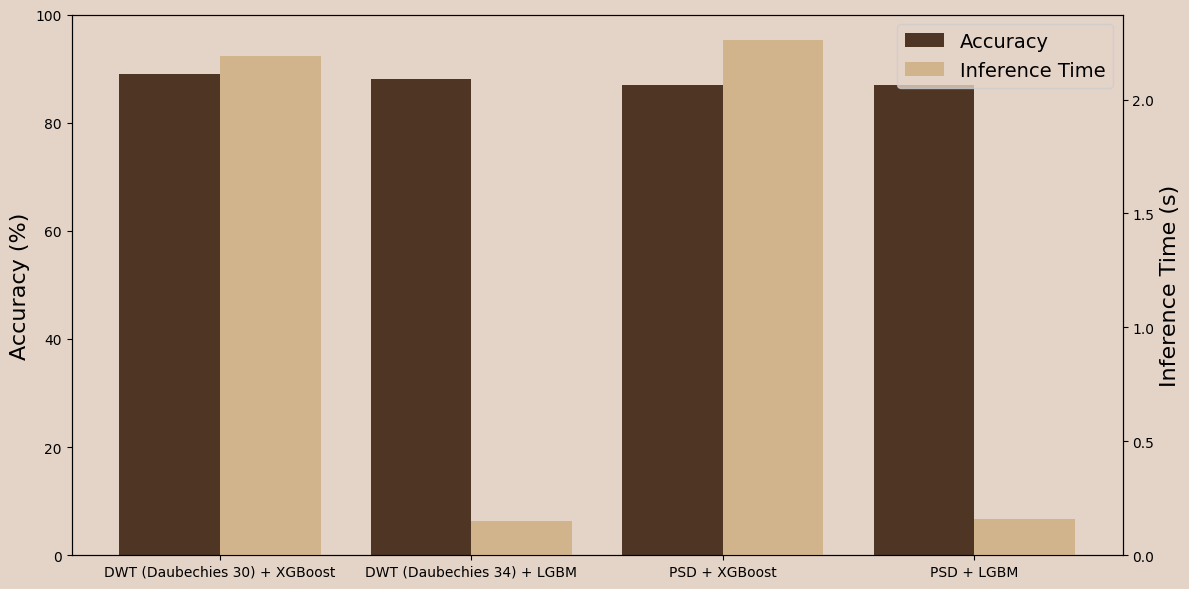

In [ ]:
row_dict = [
    {"Model": "DWT (Daubechies 30) + XGBoost", "Accuracy": 0.89, "F1-Score": 0.88, "Inference Time(s)": 2.19},
    {"Model": "DWT (Daubechies 34) + LGBM", "Accuracy": 0.88, "F1-Score": 0.88, "Inference Time(s)": 0.15},
    {"Model": "PSD + XGBoost", "Accuracy": 0.87, "F1-Score": 0.87, "Inference Time(s)": 2.26},
    {"Model": "PSD + LGBM", "Accuracy": 0.87, "F1-Score": 0.87, "Inference Time(s)": 0.16},
]
results_df = pd.DataFrame(row_dict)
results_df['Accuracy'] = results_df['Accuracy'] * 100

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))


# Set background color
fig.patch.set_facecolor('#E4D4C8')  # Wheat color
ax1.set_facecolor('#E4D4C8')  # Wheat color

# Plot accuracy bars
x = range(len(results_df['Model']))
ax1.bar(x, results_df['Accuracy'], align='center', color='#4E3524', width=0.4, label='Accuracy')
ax1.set_ylabel('Accuracy (%)', fontsize=16)
ax1.set_ylim(0, 100)
ax1.tick_params(axis='y', labelsize=10)

# Create a second y-axis for inference time
ax2 = ax1.twinx()
ax2.bar([i + 0.4 for i in x], results_df['Inference Time(s)'], align='center', color='#D2B48C', width=0.4, label='Inference Time')
ax2.set_ylabel('Inference Time (s)', fontsize=16)
ax2.tick_params(axis='y', labelsize=10)

# Set x-axis labels
plt.xticks([i + 0.2 for i in x], results_df['Model'], rotation=45, ha='right', fontsize=30)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=14)
legend.get_frame().set_facecolor("#E4D4C8")

plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
mod_model_res = model_res.copy()
mod_model_res["preproc_dim_red"] = mod_model_res["preproc_dim_red"].str.replace("-None", " only")
grouped_data = mod_model_res.groupby(["preproc_dim_red"]).agg({"score":"max", "time_taken": "mean"})
grouped_data.rename(columns={"score": "Best Accuracy", "time_taken": "Avg Training Time"}, inplace=True)
grouped_data = grouped_data.sort_values("Best Accuracy", ascending=False)

models = grouped_data.index
time_taken = grouped_data["Avg Training Time"]
accuracy = grouped_data["Best Accuracy"]

# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Plot the bars for Accuracy on the first y-axis
ax1.bar(r1, accuracy, color="#8B4513", width=bar_width, label="Best Accuracy")
ax1.set_ylabel("Best Accuracy")
ax1.set_xticks([r + bar_width/2 for r in range(len(models))])
ax1.set_xticklabels(models)
ax1.tick_params(axis="x", rotation=45)

# Create a second y-axis for Time Taken
ax2 = ax1.twinx()

# Plot the bars for Time Taken on the second y-axis
ax2.bar(r2, time_taken, color="#D2B48C", width=bar_width, label="Avg Time")
ax2.set_ylabel("Avg Training Time (seconds)")

# Set the title of the plot
ax1.set_title("Best Accuracy and Avg Training time of 100 trials")

# Add legends for both y-axes
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

NameError: name 'model_res' is not defined

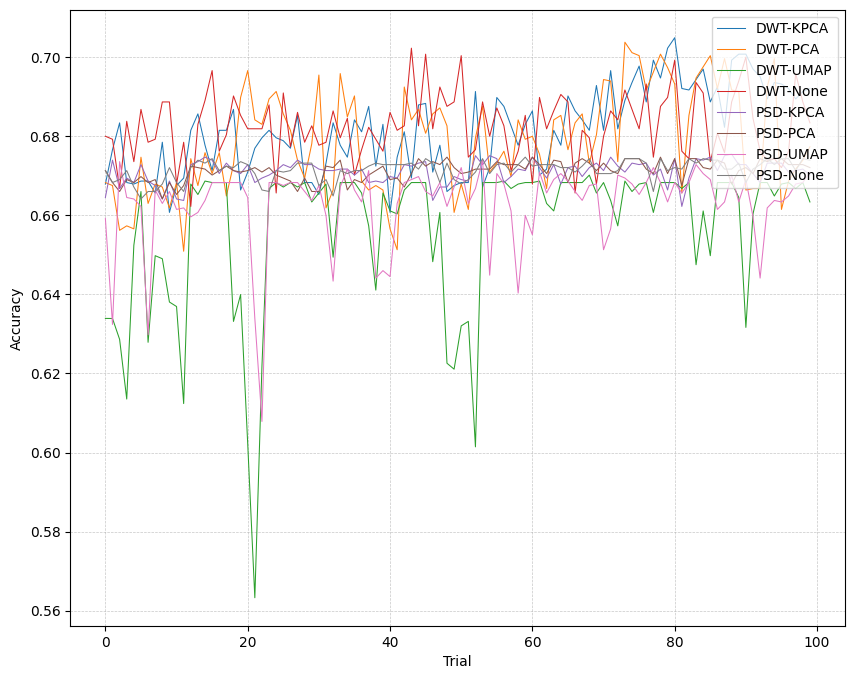

In [ ]:
plt.figure(figsize=(10, 8))
sns.lineplot(model_res, x="trial_number", y="score", hue="preproc_dim_red", linewidth=0.75)

# Move the legend to the right side
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
# Set the labels and title
plt.xlabel('Trial')
plt.ylabel('Accuracy')


plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)


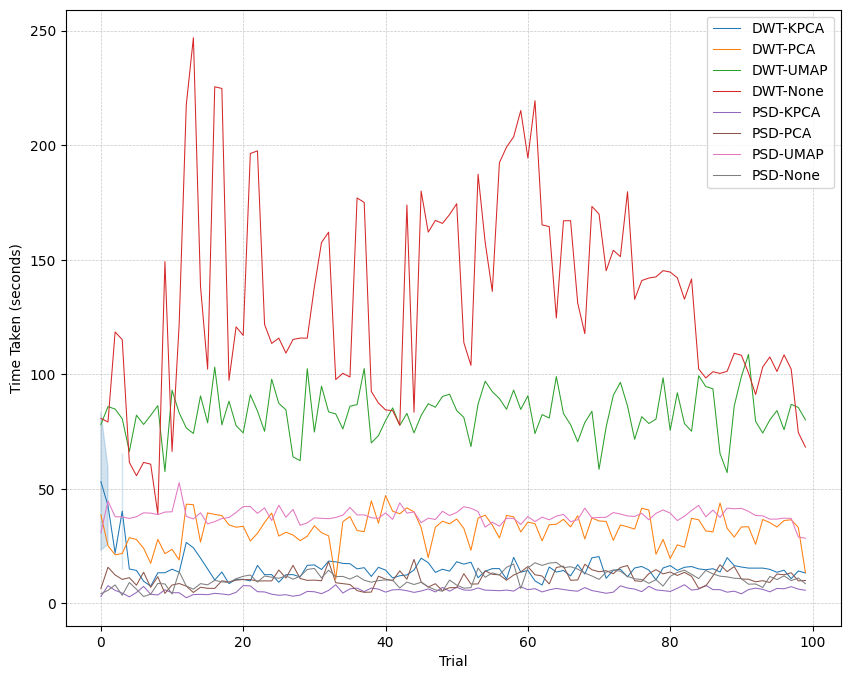

In [ ]:
plt.figure(figsize=(10, 8))
sns.lineplot(model_res, x="trial_number", y="time_taken", hue="preproc_dim_red", linewidth=0.75)

# Move the legend to the right side
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
# Set the labels and title
plt.xlabel('Trial')
plt.ylabel('Time Taken (seconds)')

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

In [ ]:
import plotly.graph_objects as go


# Extract unique values of 'preproc_dim_red'
preproc_dim_red_values = model_res[]

# Create traces for each 'preproc_dim_red' value
traces = []
for dim_red in preproc_dim_red_values:
    filtered_data = [d for d in model_res if d['preproc_dim_red'] == dim_red]
    trace = go.Scatter(
        x=[d['trial_number'] for d in filtered_data],
        y=[d['time_taken'] for d in filtered_data],
        mode='lines',
        name=dim_red,
        line=dict(width=0.75),
        hoverinfo='text',
        hovertext=[f"Trial: {d['trial_number']}<br>Time Taken: {d['time_taken']}" for d in filtered_data]
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title='Time Taken vs. Trial',
    xaxis=dict(title='Trial'),
    yaxis=dict(title='Time Taken (seconds)'),
    hovermode='closest',
    legend=dict(x=1, y=1, orientation='v'),
    width=800,
    height=600
)

# Create the figure and display the plot
fig = go.Figure(data=traces, layout=layout)
fig.show()

In [ ]:
# Visualization

# 1. Accuracy over Trials
plt.figure(figsize=(10, 6))
plt.plot(logs['trial_number'], logs['score'], marker='o')
plt.title('Accuracy over Trials')
plt.xlabel('Trial Number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# 2. Time Taken per Trial
plt.figure(figsize=(10, 6))
plt.plot(logs['trial_number'], logs['time_taken'], marker='o')
plt.title('Time Taken per Trial')
plt.xlabel('Trial Number')
plt.ylabel('Time Taken (seconds)')
plt.grid(True)
plt.show()

# 3. Cumulative Time
plt.figure(figsize=(10, 6))
plt.plot(logs['trial_number'], logs['cumulative_time'], marker='o')
plt.title('Cumulative Time Taken')
plt.xlabel('Trial Number')
plt.ylabel('Cumulative Time (seconds)')
plt.grid(True)
plt.show()

# 4. Hyperparameter Distribution (for selected important hyperparameters)
# Extracting hyperparameters into a DataFrame
params_df = logs['params'].apply(pd.Series)

# Select important hyperparameters to plot
important_hyperparams = ['preproc', 'dim_red', 'model']
fig, axes = plt.subplots(len(important_hyperparams), 1, figsize=(10, 6 * len(important_hyperparams)))
for i, param in enumerate(important_hyperparams):
    sns.countplot(data=params_df, x=param, ax=axes[i])
    axes[i].set_title(f'Distribution of {param}')
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()